<a href="https://colab.research.google.com/github/leesuyee/mesoscale-connectivity-tutorial/blob/main/mesoscale_connectivity_coding_activity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mapping the Brain: Discovering How Brain Areas Connect

In this coding tutorial, we will analyze whole-brain anatomy data from the Allen Institute to identify patterns of connectivity between brain areas and infer the function of those connections.

The dataset was collected as part of the [Thalamus in the Middle project](https://www.allenneuraldynamics.org/projects/neural-dynamics-in-multi-regional-circuits-with-thalamus-in-the-middle) at the Allen Institute for Neural Dynamics and is focused on mapping connections between the frontal cortex and thalamus.

---

Feb 13, 2025

Allen Institute Education Activity

Su-Yee Lee, Mathew Summers, Nicholas Lusk, Saskia de Vries

# Set up environment

Run the code cells below to install the necessary packages.

**DO NOT RERUN THIS CELL**


In [5]:
# install packages
!pip install s3fs==2026.1.0 pandas==2.2.2 brainglobe-atlasapi==2.3.0 matplotlib==3.10.0 numpy==2.0.2


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.0/153.0 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.8/201.8 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.7/87.7 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.2/166.2 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 100.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2026.1.0 which is incompatible.
datasets 4.0.0 requires fsspec[http]<=2025.3.0,>=2023.1.0, but you have fsspec 2026.1.0 which is incompatible.


In [6]:
# import packages
import os
from pathlib import Path
import pandas as pd
import s3fs
import matplotlib.pyplot as plt
import numpy as np
from brainglobe_atlasapi import BrainGlobeAtlas

In [7]:
# Clone github repo to access data folders
repo_url = "https://github.com/leesuyee/mesoscale-connectivity-tutorial.git" # github repo URL
repo_dir = "/content/mesoscale-connectivity-tutorial" # set up path

# Clone the repo if it hasn't been cloned yet
if not os.path.exists(repo_dir):
    print(f"Cloning repository from {repo_url}...")
    !git clone {repo_url} {repo_dir}
else:
    print(f"Repository already exists at {repo_dir}")

# Change working directory to repo root
os.chdir(repo_dir)
print("Cloned github repo" )

# Import Allen mouse atlas from data folder

# Path to the data folder
local_bg_dir = Path("/content/mesoscale-connectivity-tutorial/data/")

# Initialize atlas from the local folder
atlas = BrainGlobeAtlas(
    atlas_name="allen_mouse_25um",
    brainglobe_dir=local_bg_dir,
    check_latest=False  # disables network version check
)

# Check atlas shape
print(atlas.reference.shape)

Cloning repository from https://github.com/leesuyee/mesoscale-connectivity-tutorial.git...
Cloning into '/content/mesoscale-connectivity-tutorial'...
remote: Enumerating objects: 2626, done.
remote: Counting objects: 100% (1757/1757), done.
remote: Compressing objects: 100% (1749/1749), done.
remote: Total 2626 (delta 31), reused 1712 (delta 6), pack-reused 869 (from 3)
Receiving objects: 100% (2626/2626), 61.78 MiB | 20.75 MiB/s, done.
Resolving deltas: 100% (37/37), done.
Filtering content: 100% (1692/1692), 769.42 MiB | 19.83 MiB/s, done.
Cloned github repo
(528, 320, 456)


# Load data for a single brain

The `load_mouse` function (hidden below) loads the data for a selected mouse brain, identified by the mouse ID, from the S3 cloud storage and associated metadata from the local /metadata folder.

Let's use the `load_mouse` function and look at the data we have to work with.

In [11]:
# @title Run hidden `load_mouse` function
# Class to load SmartSPIM data asset from S3
class load_data:
    """
    Minimal Colab-compatible loader for SmartSPIM data (CCF coordinates and region counts) streamed directly from S3

    Parameters
    ----------
    mouse_ID : str | int
        Mouse ID (e.g. 689305)

        bucket : str
        S3 bucket name (e.g. "s3://aind-open-data")

        anon : bool
        Whether to use anonymous credentials (e.g. True)

        prefer_stitched : bool
        Whether to prefer stitched data (e.g. True)

    Attributes
    ----------
    rootDir : str
        Resolved S3 path to the selected SmartSPIM dataset.

    quantPaths : dict[str, str]
        Mapping from imaging channel (e.g., ``"488"``) to the
        corresponding ``cell_count_by_region.csv`` file path.

    ccfCellsPaths : dict[str, str]
        Mapping from imaging channel to the corresponding
        ``transformed_cells.xml`` file path containing CCF
        coordinates.

    channels : list[str]
        Sorted list of available imaging channels discovered
        for the dataset.

    Methods
   ----------
   resolve_paths()
        Method to get path to whole brain volume data

    getCellsCCFdf(ch: list[str])
        Retrieves and formats CCF transformed coordinates of segmented cells into a DataFrame

    getcellcounts(ch: list[str])
        Imports the cell_counts_by_region.csv as a DataFrame


    """

    def __init__(
        self,
        mouse_ID: str | int,
        bucket: str = "s3://aind-open-data",
        anon: bool = True,
        prefer_stitched: bool = True,
    ):
        self.mouse_ID = str(mouse_ID)
        self.bucket = bucket
        self.fs = s3fs.S3FileSystem(anon=anon)
        self.prefer_stitched = prefer_stitched

        self._resolve_paths()

    # Path resolution

    def _resolve_paths(self):
      """
      Method to get path to whole brain volume data
      """
      roots = self.fs.ls(self.bucket)
      matches = [r for r in roots if self.mouse_ID in r]

      if not matches:
          raise FileNotFoundError(f"No datasets found for mouse_ID {self.mouse_ID}")

      if self.prefer_stitched:
          stitched = [r for r in matches if "stitched" in r.lower()]
          if len(stitched) == 1:
              self.rootDir = stitched[0]
          elif len(stitched) > 1:
              print(f"Successfully loaded data asset for {self.mouse_ID}.")
              self.rootDir = sorted(stitched)[-1]
          else:
              self.rootDir = matches[0]
      else:
          self.rootDir = matches[0]

      quant_dir = f"{self.rootDir}/image_cell_quantification"
      if not self.fs.exists(quant_dir):
          raise FileNotFoundError("image_cell_quantification directory not found")

      quant_paths = self.fs.glob(f"{quant_dir}/Ex*")

      self.quantPaths = {
          Path(p).name.split("_")[1]: f"{p}/cell_count_by_region.csv"
          for p in quant_paths
      }
      self.ccfCellsPaths = {
          Path(p).name.split("_")[1]: f"{p}/transformed_cells.xml"
          for p in quant_paths
      }

      self.channels = sorted(self.quantPaths.keys())

    # Cell coordinates in CCF

    def getCellsCCFdf(self, ch: list[str]):
        """
        Retrieves and formats CCF transformed coordinates of segmented cells into a DataFrame

        Parameters
        ----------
        ch : list[str]
            List of imaging channels to retrieve coordinates from (e.g., ["488", "561"])

        Returns
        -------
        dfs : pd.DataFrame
            DataFrame cwhere each row is a cell and each column is a coordinate:
            AP (anterior-posterior), DV(dorsal-ventral), ML(medial-lateral),
            with an additional "channel column indicating the channel of origin
        """
        ccfDim = [528, 320, 456] # Allen mouse 25um atlas
        dfs = []

        for channel in ch:
            if channel not in self.ccfCellsPaths:
                raise KeyError(f"Channel {channel} not found")

            with self.fs.open(self.ccfCellsPaths[channel], "rb") as f:
                df = pd.read_xml(
                    f,
                    xpath="//CellCounter_Marker_File//Marker_Data//Marker_Type//Marker",
                )

            # export data in XYZ order and rename columns to AP, DV, ML
            df = (
                df[["MarkerX", "MarkerY", "MarkerZ"]]
                .rename(
                    columns={
                        "MarkerX": "AP",
                        "MarkerY": "DV",
                        "MarkerZ": "ML",
                    }
                )
                .assign(channel=channel)
            )
            # Clip coordinates within specified dimensions
            df["AP"] = df["AP"].clip(0, ccfDim[0] - 1)
            df["DV"] = df["DV"].clip(0, ccfDim[1] - 1)
            df["ML"] = df["ML"].clip(0, ccfDim[2] - 1)

            dfs.append(df)

        return pd.concat(dfs, ignore_index=True)

    # Cell counts by region

    def getcellcounts(self, ch: list[str]):
        """
        Imports the cell_counts_by_region.csv (quantifiction of detected cells in brain regions) as a DataFrame

        Parameters
        ----------
        ch : list[str]
            List of imaging channels to retrieve coordinates from (e.g., ["488", "561"]

        Returns
        -------
        dfs : pd.DataFrame
            DataFrame where each row is a brain region cell count in a given channel
        """
        required_columns = [
            "ID", "Acronym", "Name", "Struct_Info", "Struct_area_um3",
            "Left", "Right", "Total",
            "Left_Density", "Right_Density", "Total_Density",
        ]

        # Initialize an empty list to hold DataFrames
        cell_counts_list = []

        for channel in ch:
            if channel not in self.quantPaths:
                raise KeyError(f"Channel {channel} not found")

            # Load csv
            with self.fs.open(self.quantPaths[channel], "rb") as f:
                df = pd.read_csv(f)

                # Check if all required columns are present
                if set(required_columns).issubset(df.columns):
                  # Truncate the DataFrame to specific columns
                  cell_counts = df[required_columns]
                  # Add a new column indicating the channel
                  cell_counts = cell_counts.assign(channel=channel)
                  # Append to list
                  cell_counts_list.append(cell_counts)

                # Throw error if missing columns
                if not set(required_columns).issubset(df.columns):
                    raise ValueError(f"Missing required columns in {channel}")

            # Concatenate list into a single DataFrame
            if cell_counts_list:
              cell_counts_df = pd.concat(cell_counts_list, ignore_index=True)
            else:
            # return empty DataFrame if no data is found
              cell_counts_df = pd.DataFrame(columns = required_columns + ["channel"])

        return cell_counts_df

def load_metadata(
    csv_path: str,
    mouse_ID: str | int
    ) -> pd.DataFrame:

    df = pd.read_csv(csv_path)
    df["channel"] = df["channel"].astype(str) # change data type to match cell counts and cell coordinates dataframes

    df_mouse = df[df["subject_id"].astype(str) == str(mouse_ID)]
    if df_mouse.empty:
        raise ValueError(f"No metadata found for mouse_ID {mouse_ID}")

    return df_mouse

def add_injection_metadata(
    ccf_df: pd.DataFrame,
    metadata_df: pd.DataFrame
    ) -> pd.DataFrame:

  """
  Add injection parent information to cell counts and cell coordinates dataframes
  """

  inj_map = (
      metadata_df
      .set_index("channel")["inj_parent"]
  )

  return ccf_df.assign(
      inj_parent=ccf_df["channel"].map(inj_map)
  )

def load_mouse(
    mouse_ID: str | int,
    metadata_csv: str = "metadata/metadata_filtered.csv",
) -> dict[str, pd.DataFrame]:

    """
    High-level loader that returns fully packaged SmartSPIM data
    using all available channels in the dataset. Must have github repo cloned and mounted in colab.

    Parameters
    ----------
    mouse_ID : str | int
        Mouse ID (e.g. 689305)

    metadata_csv : str
        Path to the metadata CSV file

    Returns
    -------
    channels : list[str]
        List of available imaging channels

    ccf_df : pd.DataFrame
        DataFrame containing coordinates of segmented cells

    cell_counts_df : pd.DataFrame
        DataFrame containing cell counts by brain region

    metadata_df : pd.DataFrame
        DataFrame containing metadata for selected mouse ID

    """

    loader = load_data(mouse_ID)

    # Get channels in data asset
    channels = loader.channels

    if not channels:
        raise ValueError(f"No imaging channels found for mouse_ID {mouse_ID}")

    # Load raw data
    ccf_df = loader.getCellsCCFdf(channels)
    cell_counts_df = loader.getcellcounts(channels)

    # Load metadata
    metadata_df = load_metadata(metadata_csv, mouse_ID)

    # Add injection parent information from metadata
    ccf_df = add_injection_metadata(ccf_df, metadata_df)
    cell_counts_df = add_injection_metadata(cell_counts_df, metadata_df)

    return channels, ccf_df, cell_counts_df, metadata_df


In [9]:
help(load_mouse)

Help on function load_mouse in module __main__:

load_mouse(mouse_ID: str | int, metadata_csv: str = 'metadata/metadata_filtered.csv') -> dict[str, pandas.core.frame.DataFrame]
    High-level loader that returns fully packaged SmartSPIM data
    using all available channels in the dataset. Must have github repo cloned and mounted in colab.

    Parameters
    ----------
    mouse_ID : str | int
        Mouse ID (e.g. 689305)

    metadata_csv : str
        Path to the metadata CSV file

    Returns
    -------
    channels : list[str]
        List of available imaging channels

    ccf_df : pd.DataFrame
        DataFrame containing coordinates of segmented cells

    cell_counts_df : pd.DataFrame
        DataFrame containing cell counts by brain region

    metadata_df : pd.DataFrame
        DataFrame containing metadata for selected mouse ID



In [13]:
mouse_ID = 684812 # select a mouse ID
[channels, cell_coords_df, cell_counts_df, metadata_df] = load_mouse(mouse_ID)

Successfully loaded data asset for 684812.


In [82]:
# Will delete this later, using for working copy

# # Load metadata CSV
# csv_path = "metadata/metadata_filtered.csv"
# metadata_df = pd.read_csv(csv_path)
# metadata_df.channel = metadata_df.channel.astype(str)
# metadata_df.head()

,Unnamed: 0,name,subject_id,genotype,sex,virus,titer,volume,age_days,days_to_perfusion,qc_tissue,ng_link,channel,qc_channel,ng_channel,ccf_ap,ccf_ml,ccf_dv,inj_structure,inj_parent
0,5,SmartSPIM_679519_2023-08-15_11-43-09_stitched_...,679519,Ai224(TICL-NLS-EGFP-ICF-NLS-dT)-hyg/wt,Male,AAVrg-Syn-Flpo,1.020000e+14,100.0,53,31,Pass,https://aind-neuroglancer-sauujisjxq-uw.a.run....,561,Pass,https://aind-neuroglancer-sauujisjxq-uw.a.run....,115.0,275.0,114.0,FRP6a,FRP
1,6,SmartSPIM_689237_2023-08-30_19-04-37_stitched_...,689237,wt/wt,Female,AAVrg-Syn-H2B-Turquoise,2.960000e+14,50.0,52,21,Pass,https://aind-neuroglancer-sauujisjxq-uw.a.run....,445,Pass,https://aind-neuroglancer-sauujisjxq-uw.a.run....,139.0,244.0,96.0,ACAd5,ACAd
2,7,SmartSPIM_689237_2023-08-30_19-04-37_stitched_...,689237,wt/wt,Female,AAVrg-Syn-H2B-tdTomato,5.100000e+13,50.0,52,21,Pass,https://aind-neuroglancer-sauujisjxq-uw.a.run....,561,Pass,https://aind-neuroglancer-sauujisjxq-uw.a.run....,140.0,295.0,86.0,MOs5,MOs
3,8,SmartSPIM_689238_2023-08-31_01-56-52_stitched_...,689238,wt/wt,Female,AAVrg-Syn-H2B-Turquoise,2.960000e+14,50.0,52,28,Pass,https://aind-neuroglancer-sauujisjxq-uw.a.run....,445,Pass,https://aind-neuroglancer-sauujisjxq-uw.a.run....,126.0,259.0,92.0,MOs5,MOs
4,9,SmartSPIM_689238_2023-08-31_01-56-52_stitched_...,689238,wt/wt,Female,AAVrg-Syn-H2B-tdTomato,5.100000e+13,50.0,52,28,Pass,https://aind-neuroglancer-sauujisjxq-uw.a.run....,561,Pass,https://aind-neuroglancer-sauujisjxq-uw.a.run....,122.0,237.0,138.0,ILA5,ILA


# Cell Coordinates
  
# Automated Cell Detection
With this dataset, we can map how different brain structures connect with each other. First, we need to find all of the cells in the dataset and identify the brain structure they are in. Manually locating and counting all of the cells is quite laborious, especially at the whole brain scale, so cells were automatically detected using machine vision models. The rest of this tutorial will show you how to load and analyze the extracted data from the automatically detected cells.

# Explore cell coordinate data
Using the `load_mouse` function, we've created a pd.DataFrame which we named `ccf_df` which contains the spatial coordinates of the detected cells in a given channel. The coordinates are in AP (anterior-posterior), DV (dorsal-ventral), ML(medial-lateral) space. The `inj_parent` column indicates the brain structure in which the virus was injected, or the brain area that the identified cells are connected with.

In [14]:
cell_coords_df

,AP,DV,ML,channel,inj_parent
0,406,71,258,445,MOs
1,419,72,273,445,MOs
2,421,77,272,445,MOs
3,430,74,270,445,MOs
4,433,77,229,445,MOs
...,...,...,...,...,...
833397,445,131,100,561,ACAd
833398,444,136,95,561,ACAd
833399,445,135,96,561,ACAd
833400,444,136,96,561,ACAd


# Plot Heatmap of Cell Counts in Each Brain Area

We can visualize the data by plotting histograms of the cell coordinates embedded within the anatomical structures. Since this project is focused on mapping connections between the thalamus and frontal cortex, we'll plot a section of the brain centered on the thalamus in the coronal plane.
Using the atlas.get_structure_mask function, we can also overlay the brain structure boundaries to help us identify where the cell targets are.
    
You can play around with the `plane` and `window` parameters to adjust the location and thickness of the slice we plot or the roiList to outline different brain regions.

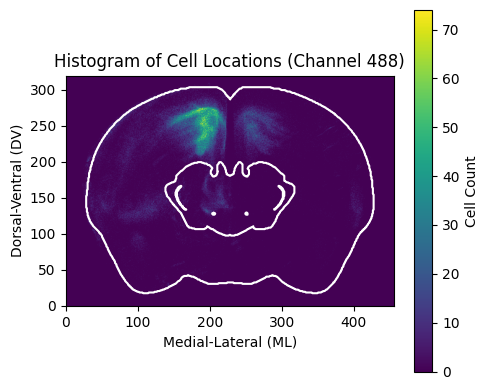

In [48]:
# Plot heatmap of cell counts in the brain
ch = channels[1] # select a channel
plane =  250 # anterior-posterior slice to plot
window = 100 # slice window bounds
roiList = ["root", "TH"] # brain structures to plot

# set figure parameters
fig, ax = plt.subplots(figsize=(5, 4))

cellLocs = cell_coords_df[cell_coords_df.channel == ch]
# generate the histogram of cell coordinates
planeLocs = cellLocs.loc[(cellLocs['AP'] >= plane - window) & (cellLocs['AP'] <= plane + window), :] # filter cellLocs to coordinates within AP slice bounds

# calculate bins for histogram
xbins = np.arange(0, atlas.get_structure_mask("root").shape[2], 1)
ybins = np.arange(0, atlas.get_structure_mask("root").shape[1], 1)

# create histogram of ML, DV coordinates
hist, xedges, yedges = np.histogram2d(
    planeLocs[planeLocs['channel'] == ch]["ML"],
    planeLocs[planeLocs['channel'] == ch]["DV"],
    bins=(xbins, ybins))

# overlay the heatmap
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
heatmap = ax.imshow(
    hist.T,  # transpose because imshow expects (rows, cols)
    extent=extent,
    origin="upper",
    cmap="viridis",
    alpha=1)

# generate contour outlines for brain structures
for roi in roiList:
    roi_mask = atlas.get_structure_mask(roi) # creates a binary array the size of the brain, mask out brain structures of interest
    ax.contour(roi_mask[plane, :, :],
        levels=[0.5],
        colors="white",
        linewidths=1.5,
        origin="upper") # plotting features for structure outline

# add colorbar and labels
cbar = plt.colorbar(heatmap, ax=ax)
cbar.set_label("Cell Count")
plt.title(f"Histogram of Cell Locations (Channel {ch})")
plt.xlabel("Medial-Lateral (ML)")
plt.ylabel("Dorsal-Ventral (DV)")

plt.tight_layout()
plt.show()

# Cell Counts Per Brain Area

The coordinates of each cell are used to identify the brain structure that each cells is in. The cell counts in each brain structure are tabulated and stored in a pd.DataFrame which we named `cell_counts_df`. Let's take a closer look.

| Column    | Description |
| -------- | ------- |
| ID  | number id of brain structure   |
| Acronym | shorthand name of brain structure     |
| Name | full name of brain structure     |
| Struct_Info    | mid = structure crosses the midline, hemi = structure disconnected across midline  |
| Struct_area_um3   | volume of brain structure    |
| Left    | left hemisphere cell counts    |
| Right    | right hemisphere cell counts   |
| Total    | total cell counts   |
| Left_Density    | density of cells in left hemisphere of brain structure  |
| Right_Density    | density of cells in right hemisphere of brain structure  |
| Total_Density    | density of cells in total brain structure   |
| channel    | channel name    |
| inj_parent  | brain structure injection site |

In [32]:
cell_counts_df

,ID,Acronym,Name,Struct_Info,Struct_area_um3,Left,Right,Total,Left_Density,Right_Density,Total_Density,channel,inj_parent
0,997,root,root,mid,5.113271e+11,98427,22800,121227,3.849864e-07,8.917970e-08,2.370831e-07,445,MOs
1,8,grey,Basic cell groups and regions,hemi,2.312776e+11,97349,22574,119923,4.209185e-07,9.760566e-08,2.592621e-07,445,MOs
2,567,CH,Cerebrum,hemi,1.414069e+11,93998,20359,114357,6.647341e-07,1.439746e-07,4.043544e-07,445,MOs
3,688,CTX,Cerebral cortex,hemi,1.137573e+11,93728,20348,114076,8.239295e-07,1.788720e-07,5.014007e-07,445,MOs
4,695,CTXpl,Cortical plate,hemi,1.093212e+11,91238,20312,111550,8.345867e-07,1.858011e-07,5.101939e-07,445,MOs
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2509,129,V3,third ventricle,mid,1.139386e+09,1,0,1,1.755332e-09,0.000000e+00,8.776659e-10,561,ACAd
2510,140,AQ,cerebral aqueduct,mid,4.506497e+08,5,3,8,2.219019e-08,1.331411e-08,1.775215e-08,561,ACAd
2511,145,V4,fourth ventricle,mid,1.372785e+09,113,6,119,1.646289e-07,8.741355e-09,8.668510e-08,561,ACAd
2512,153,V4r,lateral recess,hemi,3.813698e+08,107,3,110,2.805676e-07,7.866381e-09,1.442170e-07,561,ACAd


# Compare Connectivity Across Brain Areas

To help us assess the connectivity across brain regions, we can use cell_counts_df to construct a connectivity matrix.  
    
First, filter the cell counts dataframe to cells within thalamic subregions.  Next, use pivot_table to tabulate the connectivity matrix. Rows = channels, columns = brain structure, values = total density (# cells/um3)

In [30]:
# thalamic subregions of interest (leaf nodes)
roiList = ["MD", "PT", "IAD", "PVT", "IMD", "CM", "PCN", "CL"]

# filter the df for cells within the roiList
filtered_cell_counts_df = cell_counts_df[cell_counts_df["Acronym"].isin(roiList)]

conn_mat = filtered_cell_counts_df.pivot_table(index = "inj_parent",
                                      columns = "Acronym",
                                      values = "Total_Density")
conn_mat

Acronym,CL,CM,IAD,IMD,MD,PCN,PT,PVT
inj_parent,,,,,,,,
ACAd,0.000001,0.000001,0.000009,1.122181e-07,3.506187e-07,1.823329e-07,5.449009e-07,6.435932e-08
MOs,0.000001,0.000001,0.000002,3.137007e-07,4.099593e-07,1.291848e-06,9.759419e-08,1.989288e-07


Discuss:

to do - add discussion question here about observations about differences

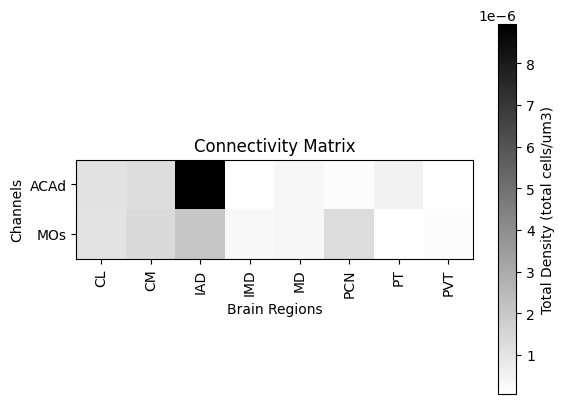

In [31]:
# plot the connectivity matrix as a heatmap

plt.imshow(conn_mat, cmap="gray_r")
plt.colorbar(label="Total Density (total cells/um3)")
plt.xticks(ticks=range(len(conn_mat.columns)), labels=conn_mat.columns, rotation=90)
plt.yticks(ticks=range(len(conn_mat.index)), labels=conn_mat.index)
plt.title("Connectivity Matrix")
plt.xlabel("Brain Regions")
plt.ylabel("Injection Structure")
plt.show()